# benchmarking on omnipath


In [1]:
from scprint import scPrint
from scprint.tasks import GRNfer

from bengrn import BenGRN
import scanpy as sc

from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
import numpy as np

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.i

In [2]:
model = scPrint.load_from_checkpoint(
    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
#    '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
NUM_GENES = 5000
MAXCELLS = 1024

RuntimeError caught: scPrint is not attached to a `Trainer`.


In [3]:
CELLTYPES = [
    'kidney distal convoluted tubule epithelial cell',
    'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney collecting duct principal cell',
    'mesangial cell',
    'blood vessel smooth muscle cell',
    'podocyte',
    'macrophage',
    'leukocyte',
    'kidney interstitial fibroblast',
    'endothelial cell'
]

In [4]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad')
#adata = sc.read_h5ad('../data/yBCKp6HmXuHa0cZptMo7.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
adata

AnnData object with n_obs × n_vars = 15728 × 70116
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', 'leide

In [5]:
metrics = {}
clf_omni = None
celltype = CELLTYPES[0]

In [ ]:
grn_inferer = GRNfer(model, adata[adata.X.sum(1) > 500],
                    how="most var across",
                    preprocess="softmax",
                    head_agg='none',
                    filtration="none",
                    forward_mode="none",
                    organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                    num_genes=NUM_GENES,
                    max_cells=MAXCELLS,
                    doplot=False,
                    batch_size=32,
                    )
grn = grn_inferer(layer=list(range(model.nlayers))[:], cell_type=celltype)
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['GRN'].mean(-1)

In [11]:
grn.varp['GRN'] = grn.varp['GRN'].T

base enrichment
Top central genes: []


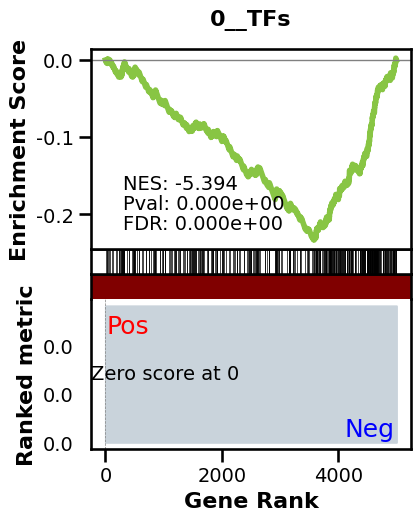

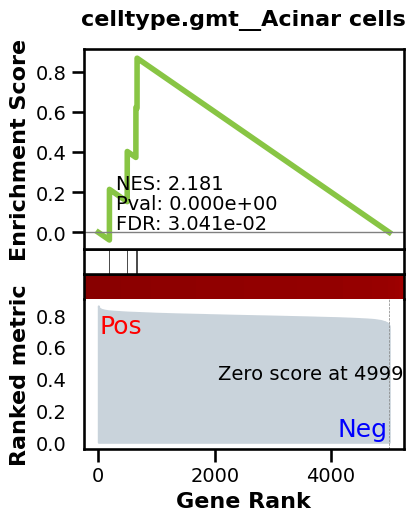

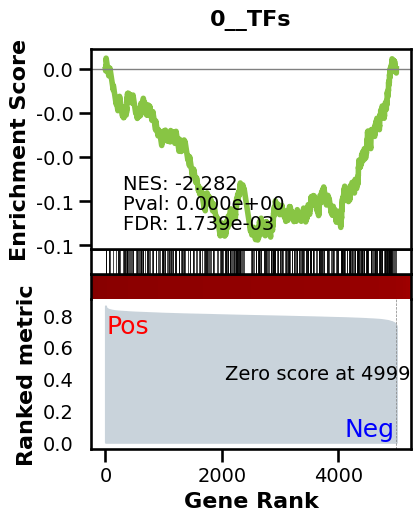

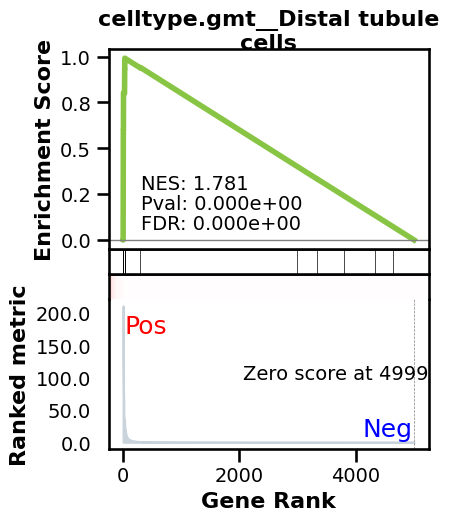

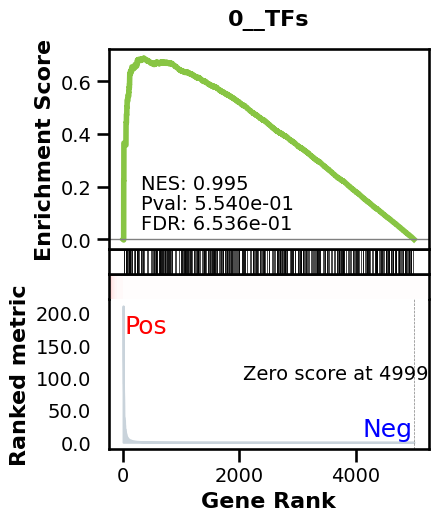

_________________________________________
TF specific enrichment
found some significant results for  14.705882352941176 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3484 genes
intersection pct: 0.6968
precision:  0.0008261483363013599 
recall:  1.0 
random precision: 0.0008263855307705822


 96%|█████████▌| 123/128 [00:02<00:00, 54.92it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:749: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 51.27it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0008763394122910708
EPR: 2.6620469453287052


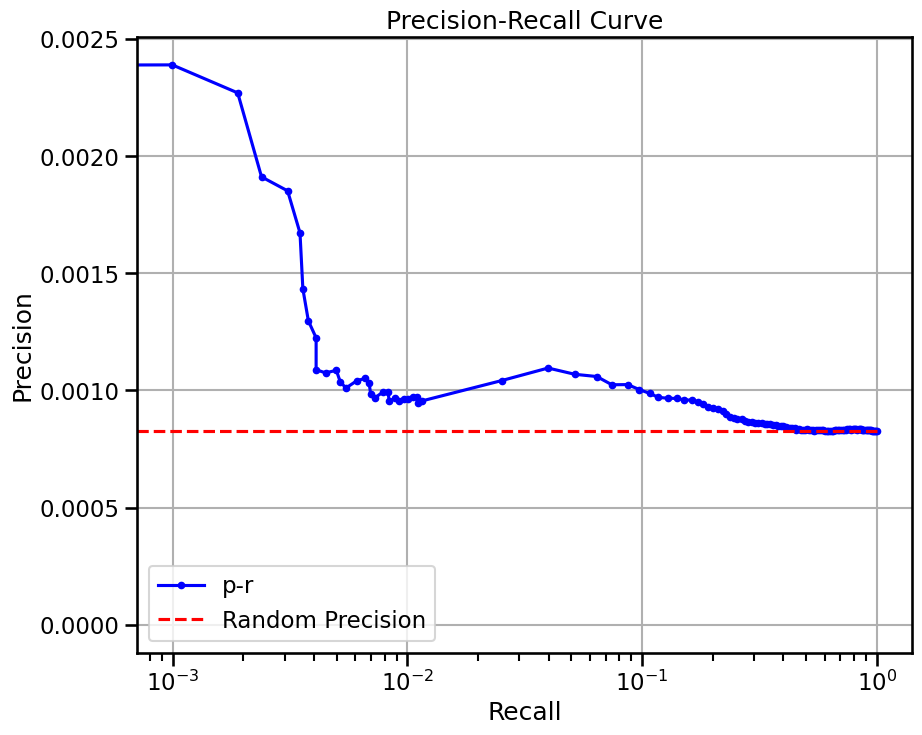

In [7]:
metrics[celltype+'_scprint_meanmostvar'] = BenGRN(grn).scprint_benchmark()

In [ ]:
metrics = {}
clf_omni = None
for celltype in CELLTYPES:
    #grn_inferer = GRNfer(model, adata[adata.X.sum(1) > 500],
    #                     how="random expr",
    #                     preprocess="softmax",
    #                     head_agg='mean',
    #                     filtration="none",
    #                     forward_mode="none",
    #                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
    #                     num_genes=2200,
    #                     max_cells=MAXCELLS,
    #                     doplot=False,
    #                     batch_size=32,
    #                     )
    #grn = grn_inferer(layer=list(range(model.nlayers))[:], cell_type=celltype)
    #grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
    #metrics[celltype+'_scprint_full'] = BenGRN(grn).scprint_benchmark()
    #del grn
    grn_inferer = GRNfer(model, adata[adata.X.sum(1) > 500],
                         how="most var across",
                         preprocess="softmax",
                         head_agg='none',
                         filtration="none",
                         forward_mode="none",
                         organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                         num_genes=NUM_GENES,
                         max_cells=MAXCELLS,
                         doplot=False,
                         batch_size=32,
                         )
    grn = grn_inferer(layer=list(range(model.nlayers))[:], cell_type=celltype)
    grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
    grn.varp['all'] = grn.varp['GRN']
    grn.varp['GRN'] = grn.varp['GRN'].mean(-1)
    metrics[celltype+'_scprint'] = BenGRN(grn).scprint_benchmark()
    
    if clf_omni == None:
        grn.varp['GRN'] = grn.varp['all']
        print("train classifier")
        _, m, clf_omni = train_classifier(grn, C=0.02, train_size=0.4, class_weight={
                                        1: 200, 0: 1}, shuffle=False, max_iter=600, return_full=False)
        grn.varp['GRN'] = grn.varp['all'][:,:,clf_omni.coef_[0] > 0].mean(-1)
    else:
        grn.varp['GRN'] = grn.varp['all'][:,:,clf_omni.coef_[0] > 0].mean(-1)
    print("scprint_benchmark2")
    metrics[celltype+'_scprint_class'] = BenGRN(grn).scprint_benchmark()
    del grn

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:172: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs["organism_ontology_term_id"][0]],


In [ ]:
m

In [ ]:
metrics

### we have 50% of the omnipath coming from protein interaction type stuff. the model doesn't get necessarily a ton better without it.

### we have 75% less sources in the transcript only dataset and similar amount of targets.

### in the end we get that most transcript level ground truth doesn't overlap the ppi level one. so dropping it would help in the results but on both side. and it should not help too much with EPR


In [ ]:
a

In [ ]:
metrics

In [ ]:
res = []
for k, v in metrics.items():
    res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df